In [1]:
import os
import pandas as pd
import h5py

%matplotlib inline

from IPython.display import display, HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [64]:
# Daysim data
trip = pd.read_csv(r'../../../outputs/daysim/_trip.tsv', sep='\t')
person = pd.read_csv(r'../../../outputs/daysim/_person.tsv', sep='\t')
hh = pd.read_csv(r'../../../outputs/daysim/_household.tsv', sep='\t')

In [65]:
pd.options.display.float_format = '{:0,.2f}'.format

In [66]:
# Weekdays in year
annual_factor = 300

## Miles Driver per Person per Day

In [67]:
df = pd.read_excel(r'../../../outputs/network/network_summary_detailed.xlsx', sheetname='UC VMT')
tot_vmt = df.drop(['@lttrk','@mveh','@hveh','@bveh'], axis=1).sum().sum()
tot_pop = person['psexpfac'].sum()
x = tot_vmt/tot_pop
print '{:0,.1f}'.format(x)

20.0


## Hours of Congestion per Person per Year
For Puget Sound drivers

In [68]:
net_sum = pd.read_excel(r'../../../outputs/network/network_summary_detailed.xlsx', sheetname='UC Delay')
veh_delay = net_sum.drop(['@lttrk','@mveh','@hveh','@bveh'], axis=1).sum().sum()
tot_pop = person['psexpfac'].sum()
x = (veh_delay/tot_pop)*annual_factor
print '{:0,.1f}'.format(x)

34.4


## Annual Hours of Delay by Average Truck
Average annual delay (hours) per truck trip in and through the region

In [69]:
# Load truck trips
df = pd.read_csv(r'../../../outputs/network/trucks.csv')

# Truck delay
net_sum = pd.read_excel(r'../../../outputs/network/network_summary_detailed.xlsx', sheetname='UC Delay')

# Annual delay hours
daily_delay = net_sum[['@mveh','@hveh']].sum().sum()


# total truck trips
trips = df['prod'].sum()

# average annual delay hours per truck
x = (daily_delay*annual_factor)/trips
print'{:0,.1f}'.format(x)

61.1


----
*Medium trucks only*

In [70]:
x = (net_sum['@mveh'].sum()*annual_factor)/df[df['Unnamed: 0'] == 'mt']['prod'].values[0]
print '{:0,.1f}'.format(x)

52.2


---
*Heavy trucks only*

In [71]:
x = (net_sum['@hveh'].sum()*annual_factor)/df[df['Unnamed: 0'] == 'ht']['prod'].values[0]
print '{:0,.1f}'.format(x)

95.9


## % Population Biking and Walking

In [72]:
trip_person = pd.merge(trip,person,on=['hhno','pno'], how='left')
bike_walk_trips = trip_person[trip_person['mode'].isin([1,2])]

df = bike_walk_trips.groupby(['hhno','pno']).count()
df = df.reset_index()
df = df[['hhno','pno']]
df['bike_walk'] = True

df = pd.merge(person,df,on=['hhno','pno'], how='left')
df['bike_walk'] = df['bike_walk'].fillna(False)

pd.options.display.float_format = '{:,.1%}'.format
pd.DataFrame(df.groupby('bike_walk').sum()['psexpfac']/df['psexpfac'].sum())

,psexpfac
bike_walk,
False,71.9%
True,28.1%


## Household and Jobs within 1/4 mile transit

In [73]:
# Network data
df = pd.read_excel(r'../../../outputs/network/network_summary_detailed.xlsx', sheetname='Transit Job Access')

**Households**

In [74]:
x = df.loc['hh_p']['quarter_mile_transit']
print '{:,.0f}'.format(x) + " households"

702,604 households


In [75]:
x = (df.loc['hh_p']['quarter_mile_transit']*1.0)/df.loc['hh_p']['total']
print '{:,.1%}'.format(x) + " of total households"

46.6% of total households


**Jobs**

In [76]:
x = df.loc['emptot_p']['quarter_mile_transit']
print '{:,.0f}'.format(x) + " jobs"

1,366,266 jobs


In [77]:
x = (df.loc['emptot_p']['quarter_mile_transit']*1.0)/df.loc['emptot_p']['total']
print '{:,.1%}'.format(x) + " of total jobs"

68.0% of total jobs


## Percent of Population within 1/2 fmile of frequent transit
15 minute frequency during AM/PM peak

## Highway Peak Period Travel Times
Corridors (Zone to Zone travel times)

In [64]:
# Load observed data (2013 currently)
od_obs = pd.read_csv(r'..\..\..\scripts\summarize\inputs\network_summary\od_travel_times.csv')

In [65]:
user_class = 'svtl1t'
max_internal_zone = 3700
zone_list = [532,2286,1552,1125]

# Need zone terminal times to compare to observed
o_tt = pd.read_csv(r'..\..\..\inputs\IntraZonals\origin_tt.in',
                   sep=' ',header=4)


o_tt.index = o_tt.index.get_level_values(1)
o_tt['taz'] = o_tt.index
o_tt['terminal_time'] = o_tt['matrix=mo"prodtt"']
o_tt = pd.DataFrame(o_tt[['terminal_time','taz']])

results_dict = {}

for skim_name in ['7to8','10to14','17to18']:
    user_class_dict = {}
    for user_class in ['svtl2t','h3tl2t']:
        results = pd.DataFrame()
        h5_contents = h5py.File(r'..\..\..\inputs' + r'\\' + skim_name + '.h5')
        for zone in zone_list:
            df = pd.DataFrame()
            df[user_class] = h5_contents['Skims'][user_class][:][zone-1,:max_internal_zone]
            df['otaz'] = zone
            df['dtaz'] = df.index+1
            df['travel_time'] = df[user_class]/100 # skim data is stored in hundreds

            df = df[df['dtaz'].isin(zone_list)]

    #      Subtract the terminal times
            df = pd.merge(df,o_tt,left_on='dtaz',right_on='taz')
            # Subtract destination terminal time
            df['travel_time'] = df['travel_time']-df['terminal_time']
            # Subtract origin terminal time
            df['travel_time'] = df['travel_time']-(o_tt[o_tt['taz'] == zone]['terminal_time'].values[0])

            results = results.append(df)

        user_class_dict[user_class] = results
    results_dict[skim_name] = user_class_dict

**AM Travel Times**

In [109]:
df = results_dict['7to8']['svtl2t']
# df = results_dict['10to14']['svtl2t']
df = pd.merge(df,od_obs,on=['otaz','dtaz'])
df = df[['o_city','d_city','travel_time','optimistic','best_guess','pessimistic','time']]
df['corridor']=df['o_city']+'-'+df['d_city']
df = df[df['time'] == 'am']

df = df.rename(columns={'travel_time':'travel_time_model',
                   'optimistic':'observed_low',
                  'best_guess':'observed_mid',
                   'pessimistic':'observed_high'})
df.index = df.corridor
pd.options.display.float_format = '{:0,.0f}'.format
df.drop(['corridor','time'], axis=1)

,o_city,d_city,travel_time_model,observed_low,observed_mid,observed_high
corridor,,,,,,
Seattle-Bellevue,Seattle,Bellevue,22,17,22,29
Seattle-Everett,Seattle,Everett,43,31,34,41
Everett-Seattle,Everett,Seattle,65,44,50,76
Everett-Bellevue,Everett,Bellevue,60,37,45,68
Bellevue-Seattle,Bellevue,Seattle,26,19,26,41
Bellevue-Everett,Bellevue,Everett,40,30,33,37


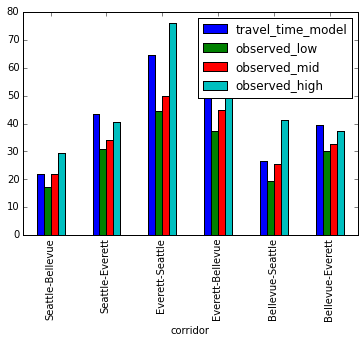

In [110]:
df.plot(kind='bar')

**PM Travel Times**

In [111]:
df = results_dict['17to18']['svtl2t']
# df = results_dict['10to14']['svtl2t']
df = pd.merge(df,od_obs,on=['otaz','dtaz'])
df = df[['o_city','d_city','travel_time','optimistic','best_guess','pessimistic','time']]
df['corridor']=df['o_city']+'-'+df['d_city']
df = df[df['time'] == 'pm']

df = df.rename(columns={'travel_time':'travel_time_model',
                   'optimistic':'observed_low',
                  'best_guess':'observed_mid',
                   'pessimistic':'observed_high'})
df.index = df.corridor
df.drop(['corridor','time'], axis=1)

,o_city,d_city,travel_time_model,observed_low,observed_mid,observed_high
corridor,,,,,,
Seattle-Bellevue,Seattle,Bellevue,26,16,22,31
Seattle-Everett,Seattle,Everett,64,42,52,68
Everett-Seattle,Everett,Seattle,48,44,53,70
Everett-Bellevue,Everett,Bellevue,41,30,34,41
Bellevue-Seattle,Bellevue,Seattle,25,24,34,51
Bellevue-Everett,Bellevue,Everett,61,38,49,64


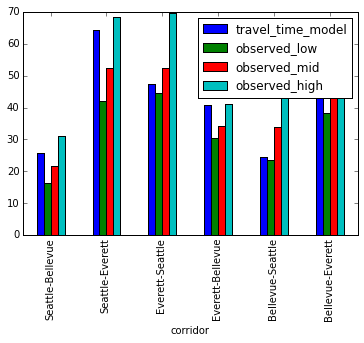

In [100]:
df.plot(kind='bar')

## Annual Travel Cost per Household 
by income

In [78]:
df = trip.groupby('hhno').sum()['travcost']
df = df.reset_index()
df = pd.merge(hh,df,on='hhno',how='left')
df['travcost'] = df['travcost'].fillna(0)
x = df['travcost'].mean()*annual_factor
print '{:,.0f}'.format(x)

3,366


In [79]:
max_income = 200000 # in 
income_bins = [i for i in xrange(0,max_income,10000)]
income_bins.append(1000000000)
income_labels = [str(i) for i in xrange(10000,max_income,10000)]
income_labels.append(str(max_income)+'+')
df['income'] = pd.cut(df['hhincome'],bins=income_bins,labels=income_labels)
df = pd.DataFrame(df.groupby('income').mean()['travcost'])
df['annual_cost'] = df['travcost']*annual_factor

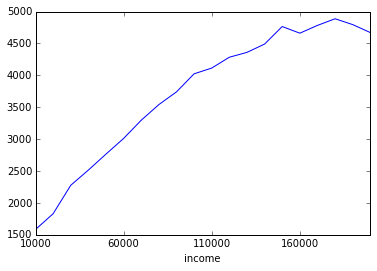

In [80]:
pd.options.display.float_format = '{:0,.2f}'.format
df['annual_cost'].plot()